### HW 1 A). Simulate a single kinesin-type motor stepping along a microtubule (MT)

In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

In [4]:
def simulation(n, time_step, step_length, p_step_forward, p_fall_off):
    max_distances =[]
    for i in range(1, n+1):
        loc = 0.0 #current location of motor
        t = 0.0 #current time
        while True:
            t = t + time_step # update simulation time
            r1 = random.random() # generate a random number to decide whether step forward, drop off, or stay
            if r1 < p_step_forward:
                loc = loc + step_length
            elif r1 < (p_step_forward + p_fall_off):
                break
        max_distances.append(loc)
    return max_distances

In [5]:
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_dev = stats.sem(data)
    h = std_dev * stats.t.ppf((1 + confidence) / 2., n - 1)
    return mean-h, mean, mean+h

### HW 1 B). Simulate different numbers of trials and plot the histograms

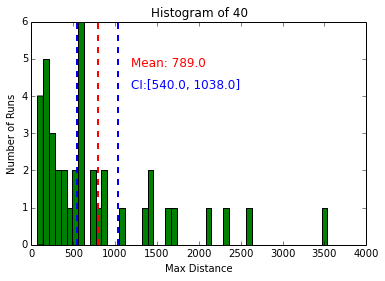

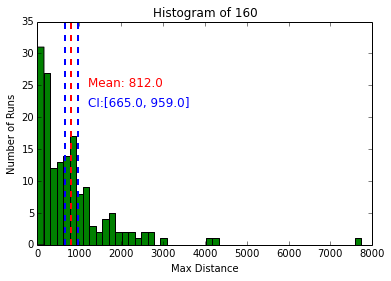

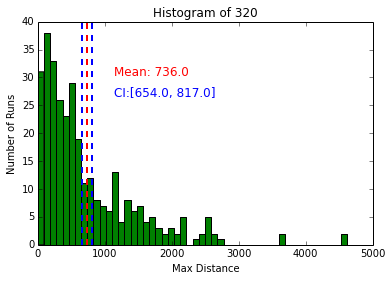

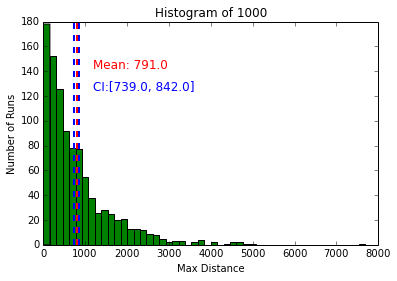

In [6]:
time_step = 1./10000
step_length = 8.
p_step_forward = 1./100
p_fall_off = 1./10000
sample_szs = [40, 160, 320, 1000]#, 5000, 10000
for n in sample_szs:
    dists = np.array(simulation(n, time_step, step_length, p_step_forward, p_fall_off))
    lci, mean, rci = mean_confidence_interval(dists, confidence=0.95) # left and right confidence interval and mean
    hist = plt.hist(dists, bins = 50, color = 'g')
    plt.axvline(x=mean, color='r', linewidth=2, linestyle='dashed')
    plt.axvline(x=lci, color='b', linewidth=2, linestyle='dashed')
    plt.axvline(x=rci, color='b', linewidth=2, linestyle='dashed')
    plt.text(mean + 400., hist[0].max()*0.8, 'Mean: '+ str(round(mean)), fontsize=12, color = 'r')
    plt.text(mean + 400., hist[0].max()*0.7, 'CI:[' + str(round(lci)) + ", "+ str(round(rci)) + "]", fontsize=12, color = 'b')
    plt.title("Histogram of " + str(n))
    plt.xlabel("Max Distance")
    plt.ylabel("Number of Runs")
    plt.show()

### HW 1 C). Determine the 95% Confidence Intervals and the proprotion of correct CIs 

In [7]:
def compute_proportion(CIs, mean= 800):
    n = len(CIs)
    nci_include_mean = 0.
    for i in range(n):
        lci, _ ,rci = CIs[i]
        if lci <= mean <= rci:
            nci_include_mean = nci_include_mean + 1
    return nci_include_mean/n
            

load CIs successful!



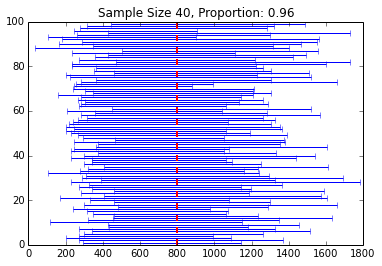

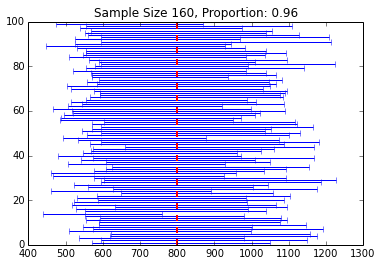

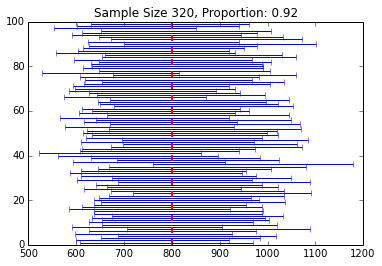

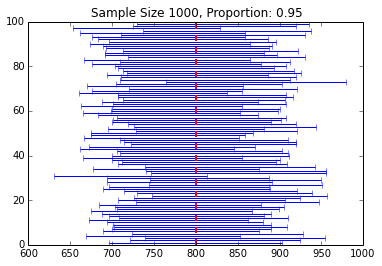

In [33]:
import time, os, pickle
from __future__ import print_function
ntrials = 100
sample_szs = [40, 160, 320, 1000] #, , 5000, 10000
props = [] # proportions record: [[sample_sz, proportion], [..], ...]

pkl_fp = 'CIs.pkl'
load_pkl = False
if os.path.exists(pkl_fp):
    load_pkl = True
    with open(pkl_fp, "rb") as pklf:
        CIs = pickle.load(pklf)
        print('load CIs successful!')
else:
    CIs = []
for idx, sample_sz in enumerate(sample_szs):
    if not load_pkl:
        print("#sample\t#run\t t run\t t past\t t remain")
        t_begin = time.time()
        CIs.append([])
        for i in range(1, ntrials + 1):
            t_i_begin = time.time()
            dists = np.array(simulation(sample_sz, time_step, step_length, p_step_forward, p_fall_off))
            lci, mean, rci = mean_confidence_interval(dists, confidence=0.95) # left and right confidence interval and mean
            CIs[idx].append([lci, mean, rci])
            t_i_end = time.time()
            t_this_run = round(t_i_end - t_i_begin, 2)
            t_past = round(t_i_end - t_begin, 2)
            t_remain = round((t_past/i)*(ntrials - i),2)
            print_str = "\r %d\t%d\t%d\t%d\t%d" % (sample_sz, i, t_this_run, t_past, t_remain)
            print(print_str, end="")
    proportion = compute_proportion(CIs[idx])
    props.append(proportion)
    print("")
    ci_ind = np.array(range(1, len(CIs[idx])))
    ci_means = np.array([CIs[idx][i-1][1] for i in ci_ind])
    ci_h = np.array([CIs[idx][i-1][1] - CIs[idx][i-1][0] for i in ci_ind])
    plt.errorbar(ci_means, ci_ind, xerr=2 * ci_h, yerr=0, linestyle='')
    plt.axvline(x=800., color='r', linewidth=2, linestyle='dashed')
    plt.title('Sample Size %d, Proportion: %.2f'% (sample_sz, proportion))
    plt.show()
if not load_pkl:
    with open(pkl_fp, 'wb') as pklf:
        pickle.dump(CIs, pklf, -1)
        print('Write CIs successful!')

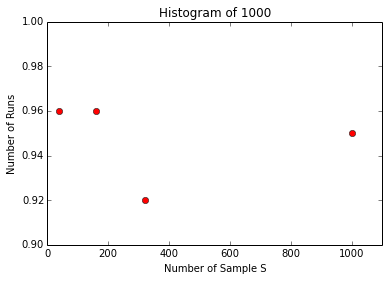

In [34]:
plt.plot(np.array(sample_szs), np.array(props),'ro')
plt.title("Histogram of " + str(n))
plt.xlabel("Number of Sample S")
plt.ylabel("Number of Runs")
plt.xlim(0,1100)
plt.ylim(0.9,1)
plt.show()

### HW 2 Velocity Variation

In [35]:
def simulation_with_time_window(n, time_step, step_length, p_step_forward, p_fall_off, time_window, velocity_criterias):
    max_distances = []
    recs_of_all = []
    for i in range(1, n + 1):
        velocity_records = []
        j = 1  # the index of time window
        last_distance = 0  # the last distance for average velocity calculation
        loc = 0.0  # current location of motor
        t = 0.0  # current time
        while True:
            t = t + time_step  # update simulation time
            r1 = random.random()  # generate a random number to decide whether step forward, drop off, or stay
            if r1 < p_step_forward:
                loc = loc + step_length
            elif r1 < (p_step_forward + p_fall_off):
                break
            if t > j * time_window:
                velocity = (loc - last_distance) / time_window
                j = j + 1
                last_distance = loc
                velocity_records.append(velocity)

        max_distances.append(loc)
        v_records = np.array(velocity_records)
        rec = []

        for v_min in velocity_criterias:
            nvs = 1 if len(v_records[v_records > v_min]) >= 1 else 0  # number of satisfied velocities
            rec.append(nvs)
        recs_of_all.append(rec)
    recs_of_all = np.array(recs_of_all)
    proportions = np.mean(recs_of_all, axis=0)
    return proportions

In [36]:
time_window = [0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.]
velocity_criterias = [900, 1200, 1600, 2400, 3600]
n = 1000
vc_list = [[] for i in range(len(velocity_criterias))]
for tw in time_window:
    proportions = simulation_with_time_window(n, time_step, step_length, p_step_forward, p_fall_off, tw, velocity_criterias)
    for i in range(len(proportions)):
        vc_list[i].append(proportions[i])

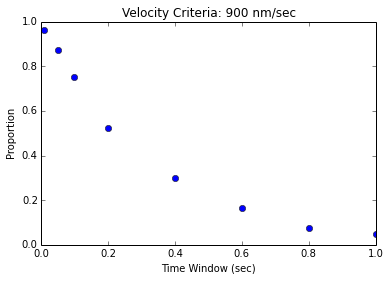

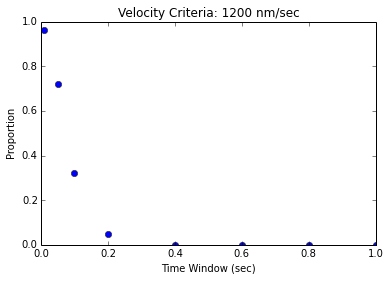

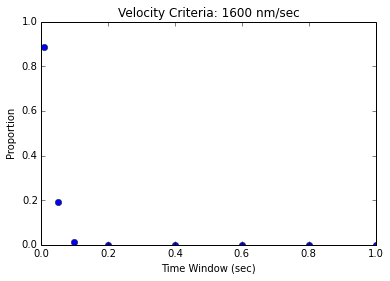

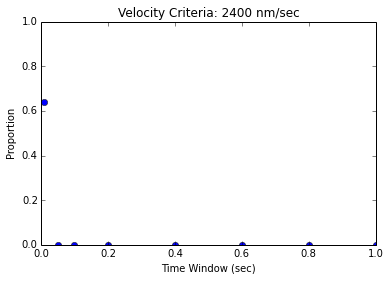

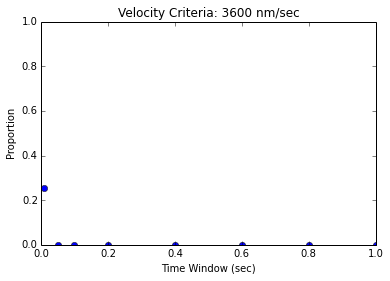

In [41]:
for i in range(len(velocity_criterias)):
    plt.plot(np.array(time_window), np.array(vc_list[i]),'bo')
    plt.title("Velocity Criteria: " + str(velocity_criterias[i]) +" nm/sec")
    plt.xlabel("Time Window (sec)")
    plt.ylabel("Proportion")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()

In [43]:
def two_moter_simulation(n_sim, time_step, step_length, p_step_forward, p_fall_off, p_rebind):
    max_distances = []
    for i in range(1, n_sim + 1):
        loc = 0.0  # current location of motor
        t = 0.0  # current time

        a_off = False # whether motor A is fall off
        b_off = False

        while True:
            t = t + time_step  # update simulation time
            r1 = random.random()  # generate a random number to decide whether motor A step forward, drop off, or stay
            r2 = random.random() # for motor B

            if (r1 <= p_step_forward) and b_off == False:
                loc = loc + step_length
            elif r1 < (p_step_forward + p_fall_off):
                a_off = True
            elif r1 < (p_step_forward + p_fall_off + p_rebind) and a_off == True:
                a_off = False
            
            if (r2 <= p_step_forward) and a_off == False:
                loc = loc + step_length
            elif r2 < (p_step_forward + p_fall_off):
                b_off = True
            elif r2 < (p_step_forward + p_fall_off + p_rebind) and b_off == True:
                b_off = False
                
            if a_off == True and b_off == True:
                break
        max_distances.append(loc)
    return max_distances

In [47]:
def two_moter_simulation(n_sim, time_step, step_length, p_step_forward, p_fall_off, p_rebind):
    max_distances = []
    for i in range(1, n_sim + 1):
        loc = 0.0  # current location of motor
        t = 0.0  # current time

        a_off = False # whether motor A is fall off
        b_off = False

        while True:
            t = t + time_step  # update simulation time
            r1 = random.random()  # generate a random number to decide whether motor A step forward, drop off, or stay
            if a_off and b_off:
                break
            elif a_off == False and b_off == False:
                if r1 <= 2 * p_step_forward:
                    loc = loc + step_length
                elif 2 * p_step_forward < r1 < 2 * p_step_forward + p_fall_off:
                    a_off = True
                elif  2 * p_step_forward + p_fall_off < r1 < 2 * (p_step_forward + p_fall_off):
                    b_off = True
            elif a_off:
                if r1 <= p_rebind:
                    a_off = False
                elif p_rebind < r1 < p_rebind + p_fall_off:
                    #b_off = True
                    break
            elif b_off:
                if r1 <= p_rebind:
                    b_off = False
                elif p_rebind < r1 < p_rebind + p_fall_off:
                    #a_off = True
                    break
        max_distances.append(loc)
    return max_distances

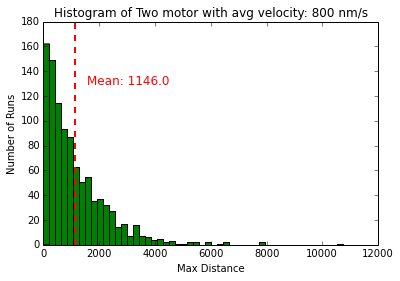

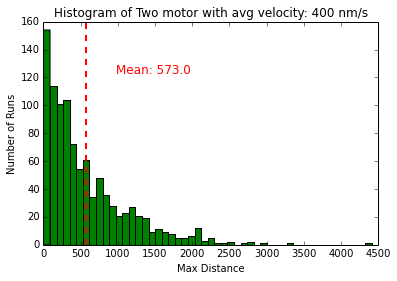

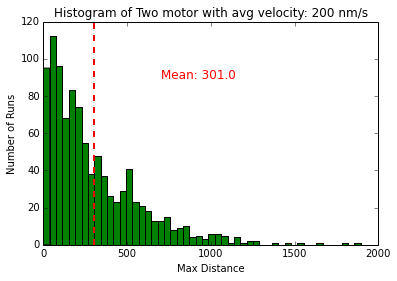

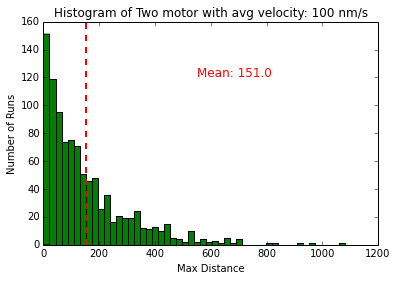

In [48]:
time_step = 1./10000
step_length = 8.
velocities = [800, 400, 200, 100]
p_step_forwards = [1./200, 1./400, 1./800, 1./1600] #corresponding to 800nm/sec, 400nm/sec, 200nm/sec, 100nm/sec
p_fall_off = 1./10000
p_rebind = 1./5000
n = 1000

for ind, p_step_forward in enumerate(p_step_forwards):
    dists = np.array(two_moter_simulation(n, time_step, step_length, p_step_forward, p_fall_off, p_rebind))
    mean_d = dists.mean()  # left and right confidence interval and mean
    hist = plt.hist(dists, bins=50, color='g')
    plt.axvline(x=mean_d, color='r', linewidth=2, linestyle='dashed')
    plt.title("Histogram of Two motor with avg velocity: " + str(velocities[ind]) + " nm/s")
    plt.text(mean_d + 400., hist[0].max()*0.8, 'Mean: '+ str(round(mean_d)), fontsize=12, color = 'r')
    plt.xlabel("Max Distance")
    plt.ylabel("Number of Runs")
    plt.show()